In [28]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score
# チャート用設定
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

init_notebook_mode(connected=True)
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [6]:
# データの読み込み
df = pd.read_csv("TOPIX4本値.csv", names=("Date", "Open", "High", "Low", "Close")).drop(0)
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2010)].copy()
df.index = range(len(df))
df["Open"] = df['Open'].astype(float)
df["Close"] = df['Close'].astype(float)
df["High"] = df['High'].astype(float)
df["Low"] = df['Low'].astype(float)
df.head()

Date    Open    High     Low   Close
0 2010-01-04  912.48  919.17  912.48  915.75
1 2010-01-05  926.07  930.51  918.14  919.57
2 2010-01-06  925.06  932.41  921.12  931.13
3 2010-01-07  933.84  937.02  929.77  931.85
4 2010-01-08  937.53  941.81  933.37  941.29

In [7]:
# Volumeが今回のデータにはない
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [8]:
#  移動平均線
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [9]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    # 終値の前日との差分
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    # 終値の上がりのみ、下がりのみでそれぞれカラムを作る
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    # 14日間の平均値上がりと、平均値下がり
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    #100-0に変換
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [10]:
# 指数平滑移動平均
# https://media-kojirokousi.com/exponential-moving-average/#:~:text=%E6%8C%87%E6%95%B0%E5%B9%B3%E6%BB%91%E7%A7%BB%E5%8B%95%E5%B9%B3%E5%9D%87%E7%B7%9A(EMA)%E3%81%AF%E3%80%81%E5%BE%93%E6%9D%A5%E3%81%AE,EMA%E3%81%A8%E5%91%BC%E3%81%B0%E3%82%8C%E3%81%BE%E3%81%99%E3%80%82
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
# MACD
# https://www.sevendata.co.jp/shihyou/technical/macd.html
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [11]:
def change_rate(df):
    #評価に終値の変化率を使うため
    #大きいプラス、小さいプラス、....大きいマイナスのような形でラベルで考えることもできる
    df['Change_rate'] = df['Close'].pct_change()
    df.loc[(df['Change_rate'] > -0.005) & (df['Change_rate'] < 0.005), 'Change_label'] = 0
    df.loc[(df['Change_rate'] >= -0.01) & (df['Change_rate'] <= -0.005), 'Change_label'] = -1
    df.loc[df['Change_rate'] < -0.01, 'Change_label'] = -2
    df.loc[(df['Change_rate'] <= 0.01) & (df['Change_rate'] >= 0.005), 'Change_label'] = 1
    df.loc[df['Change_rate'] > 0.01, 'Change_label'] = 2
    return df['Change_label']
df["Change_label"] = change_rate(df)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [13]:
# 前日のデータから、翌日の終値を予測するため、closeをshiftしている。
# ↓前日のデータを特徴量に入れたが特に重要なパラメータではなかったため、削除
# df['today_change_rate_label'] = df['Change_label']
df['Change_label'] = df['Change_label'].shift(-1)

df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price
df["Change_label"] = df["Change_label"].astype('int')

# 学習用データとテスト用データを分割
df.index = range(len(df))
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Change_rate, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Change_rate, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Change_rate,  name='Test'))
fig.show()

In [14]:
# 学習に必要ないカラムを削除
drop_cols = ['Date', 'Open', 'Low', 'High', 'Close', 'Change_rate']
train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [15]:
# closeの値を予測することにする。
y_train = train_df['Change_label'].copy()
X_train = train_df.drop(['Change_label'], 1)

y_valid = valid_df['Change_label'].copy()
X_valid = valid_df.drop(['Change_label'], 1)

y_test  = test_df['Change_label'].copy()
X_test  = test_df.drop(['Change_label'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794 entries, 0 to 1793
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        1794 non-null   float64
 1   SMA_5        1794 non-null   float64
 2   SMA_10       1794 non-null   float64
 3   SMA_15       1794 non-null   float64
 4   SMA_30       1794 non-null   float64
 5   RSI          1794 non-null   float64
 6   MACD         1794 non-null   float64
 7   MACD_signal  1794 non-null   float64
dtypes: float64(8)
memory usage: 112.2 KB


In [137]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(objective='reg:squarederror')
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.005, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100, 'random_state': 42}
Best validation score = -0.04927412267612765
CPU times: user 49min 2s, sys: 19.4 s, total: 49min 22s
Wall time: 12min 41s


In [138]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 825 ms, sys: 4.98 ms, total: 830 ms
Wall time: 209 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.005, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

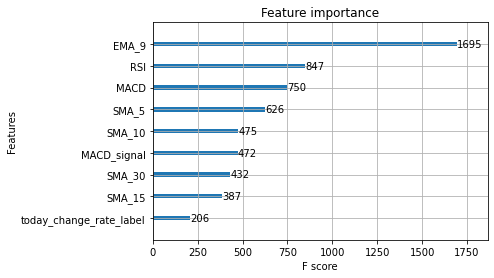

In [139]:
plot_importance(model);

In [140]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

y_true = [0. 2. 0. 2. 0.]
y_pred = [0.21387765 0.21912941 0.23658755 0.23603916 0.23658755]
mean_squared_error = 1.4922909466104157


In [142]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Change_label'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Change_label,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Change_label,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

## todo
それぞれのfit具合を出しておいて欲しい  
変数を足していくと、どのようになっていくか  
どうゆう変数をどの時に使っているか。  
waveletの変数がどのくらい寄与するかを見てみる  
次のひがupかdownかのへんかりつを用いて評価するのがだいじ　　
分類問題の方が楽だと思う変化なしという3つで考えることができる。  
大きく変化する時を当てたい  
予測に従って  
信頼度を調整するという部分も作ればいいかもしれない

## xgb
上ではxgbRegressorを用いて回帰で行っていたが、次は多クラス分類で行う

In [37]:
parameter = {
    'n_estimators': 300,
    'learning_rate': 0.001,
    'max_depth': 8,
    'gamma': 0.001,
    'random_state': 42,
    'num_class' : 5,
    'objective' : 'multi:softprob'
}
eval_set = [(X_train, y_train), (X_valid, y_valid)]
# model = xgb.XGBClassifier(objective='multi:softprob')
# clf = GridSearchCV(model, parameters)

# clf.fit(X_train, y_train)

# print(f'Best params: {clf.best_params_}')
# print(f'Best validation score = {clf.best_score_}')

model = xgb.XGBClassifier(n_estimators=300, 
    learning_rate=0.001,
    max_depth= 8,
    gamma=0.001,
    random_state= 42,
    num_class =5,
    objective='multi:softprob')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

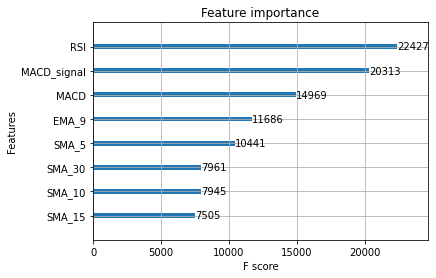

In [38]:
plot_importance(model);

In [39]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

y_true = [-1  1  1  0  0]
y_pred = [-2 -2 -2 -2 -2]
mean_squared_error = 2.6510416666666665


In [40]:
acc = accuracy_score(y_test, y_pred)
print(acc)

0.3697916666666667


In [41]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Change_label'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Change_label,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Change_label,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [43]:
pd.qcut(df['Change_rate'], 5)

0                    (0.00876, 0.0802]
1                   (-0.008, -0.00171]
2       (-0.09570000000000001, -0.008]
3                   (-0.008, -0.00171]
4                   (0.00286, 0.00876]
                     ...              
2557                 (0.00876, 0.0802]
2558               (-0.00171, 0.00286]
2559                (-0.008, -0.00171]
2560                (-0.008, -0.00171]
2561                 (0.00876, 0.0802]
Name: Change_rate, Length: 2562, dtype: category
Categories (5, interval[float64]): [(-0.09570000000000001, -0.008] < (-0.008, -0.00171] < (-0.00171, 0.00286] < (0.00286, 0.00876] < (0.00876, 0.0802]]

In [44]:
from scipy import signal
import matplotlib.pyplot as plt

import random

import numpy as np

In [51]:
def wt( data ):
    widths = np.arange(1, 100)
    cwt = signal.cwt( data, signal.ricker, widths )
    fig, ax = plt.subplots( 1, 2, figsize=(20,5) )
    ax[0].plot(data)
    ax[1].imshow(cwt, extent=[-1, 1, 1, 101], cmap='PRGn', aspect='auto', vmax=abs(cwt).max(), vmin=-abs(cwt).max())
    return cwt

[[ 1.69422327e-02  1.72630657e-02 -1.61142130e-02 ... -1.68352425e-02
  -1.63932294e-02  1.40882068e-02]
 [ 1.45326387e-02  7.30759342e-03 -7.83931981e-03 ...  5.43526990e-03
   5.29864287e-04  5.91325777e-03]
 [ 6.32906076e-03  1.82518177e-03 -4.26350750e-03 ...  1.69385016e-02
   1.64085487e-02  1.36363215e-02]
 ...
 [-3.86157868e-06 -1.43212035e-04 -2.83524812e-04 ...  5.66351995e-03
   5.72317685e-03  5.77942795e-03]
 [-9.02356924e-05 -2.25050286e-04 -3.60709546e-04 ...  5.48194230e-03
   5.54275983e-03  5.60023892e-03]
 [-1.67874692e-04 -2.98313298e-04 -4.29318160e-04 ...  5.30529747e-03
   5.36692159e-03  5.42542060e-03]]


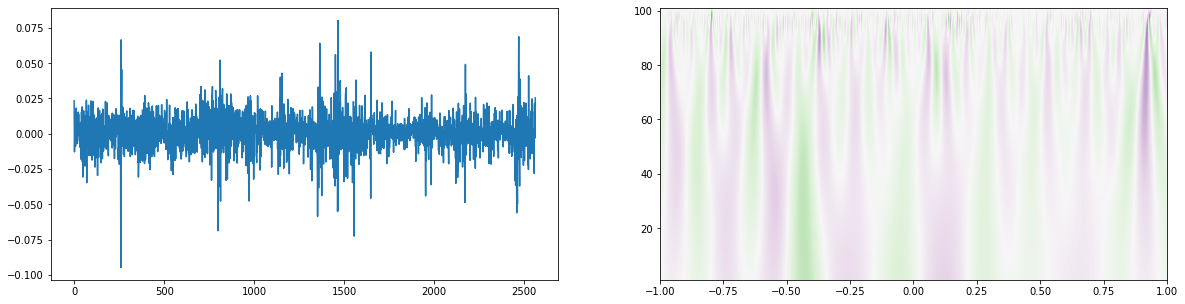

In [52]:
a = wt(df["Change_rate"])

array([[ 5.08996228, 34.21857608,  6.03075217, ..., -1.54308241,
         0.43422317, 29.49923736],
       [ 4.08307649, 25.54652807, 26.15449227, ..., 25.56308865,
        31.94381329, 25.84280021],
       [-4.47378447, 14.04856937, 26.15255088, ..., 37.61298668,
        35.58749657, 22.7802145 ],
       ...,
       [13.70487315, 17.52492876, 21.33006088, ...,  3.64674838,
        -0.55710566, -4.76695021],
       [12.75051221, 16.56200031, 20.35961219, ...,  3.07002236,
        -1.1227438 , -5.32081429],
       [11.84649097, 15.65046606, 19.44152926, ...,  2.5407715 ,
        -1.64215557, -5.8295798 ]])

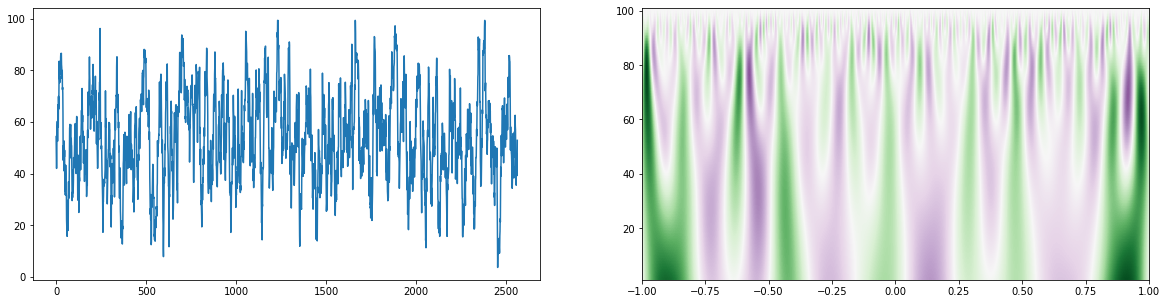

In [53]:
wt(df["RSI"])

array([[-5.63367978e-01,  5.17533314e+02,  2.01425314e+02, ...,
         3.37506970e+01,  3.45400766e+02,  8.91592315e+02],
       [ 8.74931055e-02,  5.03702197e+02,  6.87277826e+02, ...,
         9.27868426e+02,  1.17604157e+03,  8.63342870e+02],
       [ 1.20116421e+00,  4.34731675e+02,  7.33661521e+02, ...,
         1.41699327e+03,  1.24968494e+03,  7.36836873e+02],
       ...,
       [ 3.67557281e+02,  4.47145090e+02,  5.26587619e+02, ...,
        -1.39091934e+02, -2.72560066e+02, -4.05949470e+02],
       [ 3.65506158e+02,  4.44591421e+02,  5.23535081e+02, ...,
        -1.38757237e+02, -2.71807939e+02, -4.04778681e+02],
       [ 3.63480850e+02,  4.42076948e+02,  5.20535125e+02, ...,
        -1.38147738e+02, -2.70780714e+02, -4.03332868e+02]])

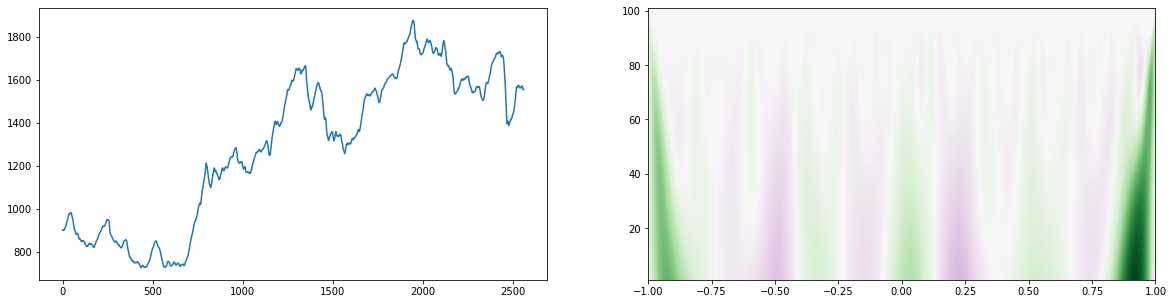

In [57]:
wt(df["EMA_9"])